**Instructions for running this notebook on Colab**
1. Run the cell below to download code from GitHub and install correct version of Python modules
2. Restart session so that Colab can use the newly installed modules rather than their previously installed versions
3. Run all cells

In [1]:
# run this cell to download data and necessary modules
import os, shutil
repo = 'fp-solvers'
if os.path.isdir(repo):
  shutil.rmtree(repo)
!git clone https://github.com/pinakm9/fp-solvers.git
!pip install -r fp-solvers/requirements.txt 2> /dev/null

Cloning into 'fp-solvers'...
remote: Enumerating objects: 14906, done.
remote: Counting objects: 100% (276/276), done.
remote: Compressing objects: 100% (148/148), done.
remote: Total 14906 (delta 127), reused 266 (delta 119), pack-reused 14630
Receiving objects: 100% (14906/14906), 804.42 MiB | 17.17 MiB/s, done.
Resolving deltas: 100% (7282/7282), done.
Updating files: 100% (14667/14667), done.
/


In [ ]:
# add modules folder to Python's search path
import os, sys
from pathlib import Path
script_dir = Path(os.path.dirname(os.path.abspath('')))
module_dir = str(script_dir)
sys.path.insert(0, repo + '/modules')
print(module_dir)

# import the rest of the modules
%matplotlib nbagg
%matplotlib inline
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt
import arch
import pandas as pd
import tensorflow_probability as tfp
import time  
import sim
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
tfd = tfp.distributions



**Set computation and plotting parameters**


In [2]:
# set up computation parameters
dim = 3
n_particles = int(1e7)
n_subdivs = 100
save_folder = '{}/non-grad3D/data/Thomas'.format(repo)
n_steps = 10
n_repeats = 50
dt = 0.1
b = 0.2
t = dt * n_steps
max_comp = int(1e6)
quad_method = 'Gauss_Legendre'
n_int_subdivs = 165
degree = 8
DTYPE = 'float32'

# set up plotting parameters
scale = 4
xlabel_size = ylabel_size = 15 + scale
tick_size = 10 + scale
legend_size = 15 + scale
title_size = 15 + scale
cbar_tick_size = 10 + scale

**Define the problem: $\mu, \sigma, p_0$**

In [3]:
def mu(X):
    bx, by, bz = tf.split(b*X, 3, axis=-1)
    sx, sy, sz = tf.split(tf.sin(X), 3, axis=-1)
    p = sy - bx 
    q = sz - by 
    r = sx - bz
    return tf.concat([p, q, r], axis=-1)

def mu_np(X):
    x, y, z = np.split(X, 3, axis=-1)
    p = np.sin(y) - b*x 
    q = np.sin(z) - b*y 
    r = np.sin(x) - b*z
    return np.concatenate([p, q, r], axis=-1)

sigma = np.sqrt(2., dtype=DTYPE)
D = sigma**2 / 2.

l = np.ones(dim, dtype=DTYPE)
g1 = tfd.MultivariateNormalDiag(loc=2*l, scale_diag=l)
g2 = tfd.MultivariateNormalDiag(loc=-2*l, scale_diag=l)
g3 = tfd.MultivariateNormalDiag(loc=[2., 2., 0.], scale_diag=l)
rv0 = tfd.Mixture(cat=tfd.Categorical(probs=[0.5, 0.5]), components=[g1, g2])
log_p0 = lambda x: tf.reshape(rv0.log_prob(x), (-1, 1))

**Set up Monte-Carlo solver**

In [4]:
X0 = rv0.sample(n_particles).numpy()
mc_prob = sim.MCProb(save_folder, n_subdivs, mu_np, sigma, X0)
mc_prob.ready(n_steps=n_steps, dt=dt, lims=None)

Time taken by propagate is 42.019458532333374 seconds
Time taken by set_grid is 29.39468479156494 seconds
Time taken by assign_pts is 36.686394691467285 seconds
Time taken by ready is 108.1009202003479 seconds


**Load the neural network**

In [5]:
n_theta = arch.LSTMForgetNet(50, 3, tf.float32, name="Thomas")
n_theta.load_weights('{}/non-grad3D/data/Thomas/400k/{}'.format(repo, n_theta.name)).expect_partial()
X = tf.random.uniform(shape=(10, dim))
n_theta(*tf.split(X, dim, axis=-1))

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[0.7024556 ],
       [0.6874086 ],
       [0.6561264 ],
       [0.65618557],
       [0.65382004],
       [0.67747724],
       [0.6695193 ],
       [0.69193643],
       [0.6900445 ],
       [0.69793105]], dtype=float32)>

**Compute, plot and save**

Streaming output truncated to the last 5000 lines.
grid_index = (27, 35), time taken = 208.4614
grid_index = (27, 36), time taken = 208.6417
grid_index = (27, 37), time taken = 208.8258
grid_index = (27, 38), time taken = 209.0052
grid_index = (27, 39), time taken = 209.1818
grid_index = (27, 40), time taken = 209.3600
grid_index = (27, 41), time taken = 209.5397
grid_index = (27, 42), time taken = 209.7188
grid_index = (27, 43), time taken = 209.8948
grid_index = (27, 44), time taken = 210.0704
grid_index = (27, 45), time taken = 210.2476
grid_index = (27, 46), time taken = 210.4247
grid_index = (27, 47), time taken = 210.6034
grid_index = (27, 48), time taken = 210.7820
grid_index = (27, 49), time taken = 210.9624
grid_index = (27, 50), time taken = 211.1427
grid_index = (27, 51), time taken = 211.3228
grid_index = (27, 52), time taken = 211.5036
grid_index = (27, 53), time taken = 211.6827
grid_index = (27, 54), time taken = 211.8619
grid_index = (27, 55), time taken = 212.0431
grid

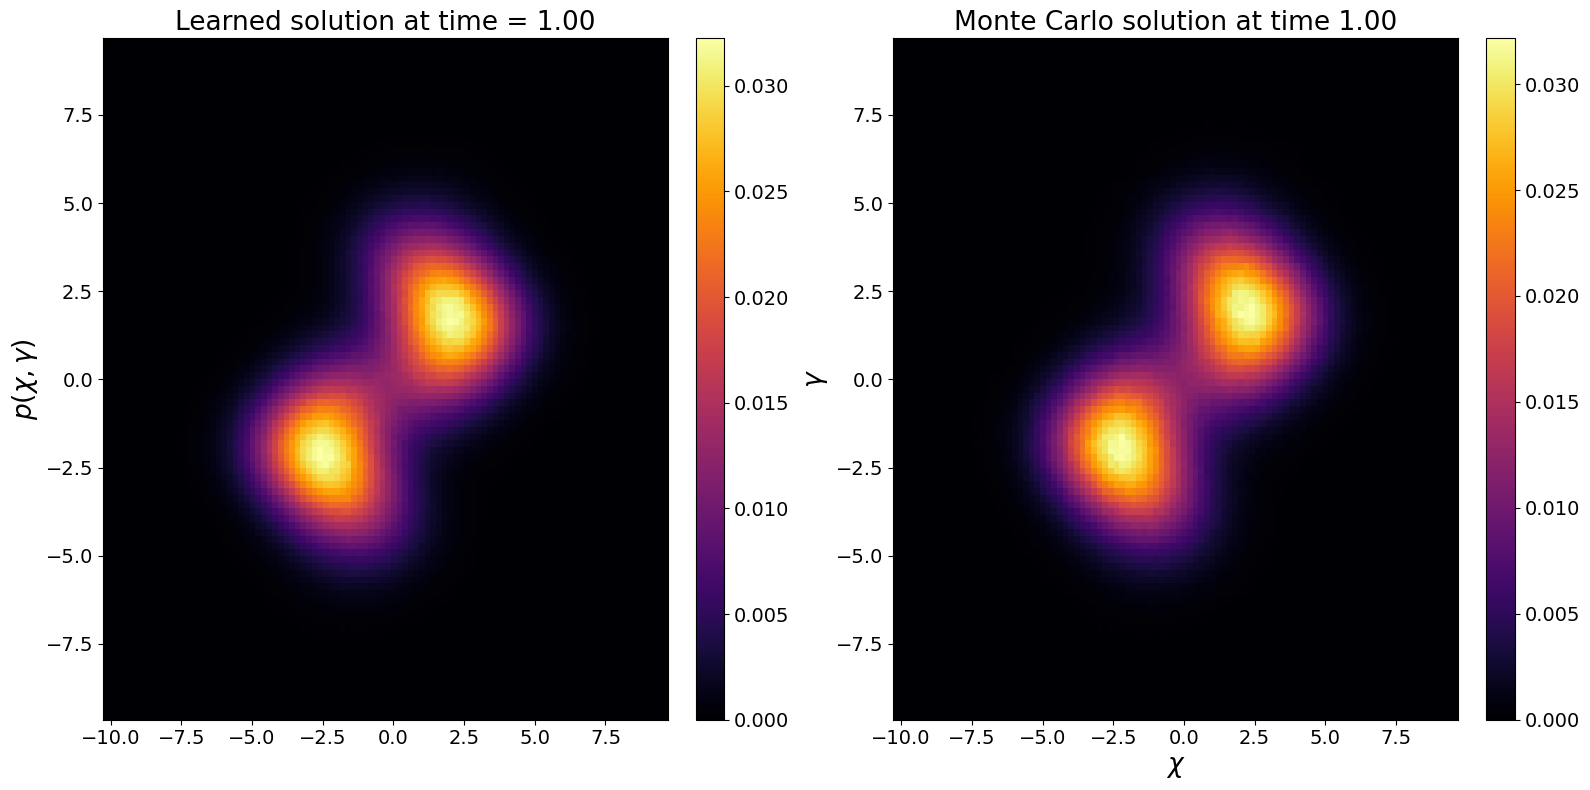

In [6]:
grid = mc_prob.get_grid()
low = grid.mins
high = grid.maxs
filter = mc_prob.save_folder + '/ensemble.csv'
prune = False

# define 6 subplots
fig_all = plt.figure(figsize=(16, 8))
ax_1l = fig_all.add_subplot(121) 
ax_1m = fig_all.add_subplot(122)


# position colorbars
div_1 = make_axes_locatable(ax_1l)
cax_1 = div_1.append_axes('right', '5%', '5%')
div_4 = make_axes_locatable(ax_1m)
cax_4 = div_4.append_axes('right', '5%', '5%')


# set label size
ax_1l.tick_params(axis='both', which='major', labelsize=tick_size)
ax_1l.tick_params(axis='both', which='minor', labelsize=tick_size)
ax_1m.tick_params(axis='both', which='major', labelsize=tick_size)
ax_1m.tick_params(axis='both', which='minor', labelsize=tick_size)


# write titles and labels
ax_1l.set_title('Learned solution at time = {:.2f}'.format(t), fontsize=title_size)
ax_1l.set_ylabel(r'$p(\chi, \gamma)$', fontsize=ylabel_size)
ax_1m.set_title('Monte Carlo solution at time {:.2f}'.format(t), fontsize=title_size)
ax_1m.set_xlabel(r'$\chi$', fontsize=xlabel_size)
ax_1m.set_ylabel(r'$\gamma$', fontsize=ylabel_size)




# compute, plot and save Monte-Carlo data
x = np.linspace(low[0], high[0], num=n_subdivs+1)[:-1].astype(DTYPE) + grid.h[0]/2. 
y = np.linspace(low[1], high[1], num=n_subdivs+1)[:-1].astype(DTYPE) + grid.h[1]/2.
z = np.linspace(low[2], high[2], num=n_subdivs+1)[:-1].astype(DTYPE) + grid.h[2]/2.


p_1m = mc_prob.compute_p2(0, 1, save=False)
p_1m  /= (p_1m.sum() * grid.h[0] * grid.h[1])
np.save('{}/p_1m.npy'.format(save_folder), p_1m)
im = ax_1m.pcolormesh(x, y, p_1m.T, cmap='inferno', shading='auto')
cbar_1m = fig_all.colorbar(im, cax=cax_4, ax=ax_1m)
cbar_1m.ax.tick_params(labelsize=cbar_tick_size)
ax_1m.set_aspect("auto")



# set up Feynman-Kac procedure
fk = sim.FK32(save_folder=save_folder, n_subdivs=n_subdivs, n_int_subdivs=n_int_subdivs, mu=mu, sigma=sigma,\
              n_theta=n_theta, grid=grid, log_p0=log_p0, max_comp=max_comp)


# compute and save Feynman-Lac solution
p_1l = fk.calc_2D_prob(n_steps, dt, n_repeats, 0, 1, filter, method=quad_method, prune=prune, num=n_int_subdivs, d=degree)
p_1l /= (p_1l.sum() * grid.h[0] * grid.h[1])
np.save('{}/p_1l.npy'.format(save_folder), p_1l)
im = ax_1l.pcolormesh(x, y, p_1l.T, cmap='inferno', shading='auto')
cbar_1l = fig_all.colorbar(im, cax=cax_1, ax=ax_1l)
cbar_1l.ax.tick_params(labelsize=cbar_tick_size)
ax_1l.set_aspect("auto")


# plot and save
fig_all.subplots_adjust(wspace=1.0, hspace=0.4)
plt.tight_layout()
plt.savefig('{}/plots/Thomas-time.png'.format(repo))

**Plot and save $p_0$**

Time taken by propagate is 3.049705982208252 seconds
Time taken by set_grid is 2.8717446327209473 seconds
Time taken by assign_pts is 3.6292197704315186 seconds
Time taken by ready is 9.551025867462158 seconds
Time taken by compute_p2 is 3.559936761856079 seconds


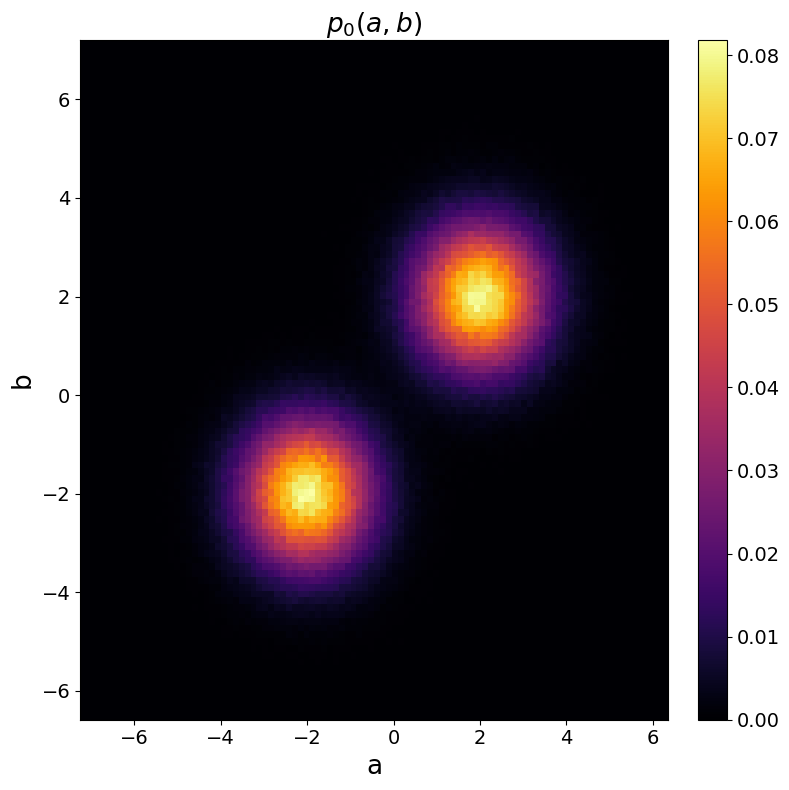

In [7]:
scale = 4
xlabel_size = ylabel_size = 15 + scale
tick_size = 10 + scale
legend_size = 15 + scale
title_size = 15 + scale
cbar_tick_size = 10 + scale

# define 6 subplots
fig_p0 = plt.figure(figsize=(8, 8))
ax = fig_p0.add_subplot(111) 


# position colorbars
div = make_axes_locatable(ax)
cax= div.append_axes('right', '5%', '5%')


# set label size
ax.tick_params(axis='both', which='major', labelsize=tick_size)
ax.tick_params(axis='both', which='minor', labelsize=tick_size)


# write titles and labels
ax.set_title(r'$p_0(a, b)$', fontsize=title_size)
ax.set_xlabel('a', fontsize=xlabel_size)
ax.set_ylabel('b', fontsize=ylabel_size)



# compute, plot and save p0 data
mc0 = sim.MCProb(save_folder, n_subdivs, mu_np, sigma, X0 = rv0.sample(int(1e6)).numpy())
mc0.ready(n_steps=0, dt=dt, lims=None)
grid = mc0.get_grid()
low = grid.mins
high = grid.maxs
x = np.linspace(low[0], high[0], num=n_subdivs+1)[:-1].astype(DTYPE) + grid.h[0]/2.
y = np.linspace(low[1], high[1], num=n_subdivs+1)[:-1].astype(DTYPE) + grid.h[1]/2.
p_0 = mc0.compute_p2(0, 1, save=False)
np.save('{}/p_0.npy'.format(save_folder), p_0)
im = ax.pcolormesh(x, y, p_0.T, cmap='inferno', shading='auto')
cbar = fig_p0.colorbar(im, cax=cax, ax=ax)
cbar.ax.tick_params(labelsize=cbar_tick_size)
ax.set_aspect("auto")
plt.tight_layout()
plt.savefig('{}/plots/Thomas-0.png'.format(repo))